In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from scipy.stats import circstd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import MDS
from sklearn_extra.cluster import KMedoids
import os, pickle

In [2]:
### open the data, combine energy with the coords. 
def get_data(path, skip_row, remove=0, explicit=False):
    csv_files = os.listdir(path)
    csv_files = [f for f in csv_files if 'csv' in f]
    csv_energy = sorted([f for f in csv_files if 'energy' in f])
    csv_coords = sorted([f for f in csv_files if 'coords' in f])
    replica_e_data = {}
    replica_c_data = {}
    skip = []
    if explicit:
        reps = [0]
    else:
        reps = [0,1,2,3,4,5,6,7,8,9]
    for c,e,rep in zip(csv_coords, csv_energy, reps):
        if skip_row:
            skip = lambda x:x%10 != 0
        replica_c_data[rep] = pd.read_csv(os.path.join(path,c), skiprows = skip).iloc[remove:,:]
        replica_e_data[rep] = pd.read_csv(os.path.join(path,e), skiprows = skip).iloc[remove:,:]
    return replica_c_data, replica_e_data

def combine_dicts(d1,d2):
    new_dict = {}
    for kv1,kv2 in zip(d1.items(),d2.items()):
        new_dict[kv1[0]] = pd.concat([kv1[1],kv2[1]], axis=0).reset_index().drop(columns='index')
    return new_dict

##### VERY IMPORANT: WHAT PART OF THE PEPTIDE TO ANALYZE
start = 2
stop = 28 

## important parameter:
explicit = False

remove = 1000 # 1000 for the REMD, 100 for tossing the 1st 40ns of the explicit solvent sims
combine_8_1s= False
if combine_8_1s:
    # this keeps the frame correct for both of the data sets, but index is over both
    path = './REMD_extracted_data/8_1_test32_REMD_1/'
    replica_c_data_32, replica_e_data_32 = get_data(path, skip_row=False, remove=remove)
    path = './REMD_extracted_data/8_1_test37_REMD_2/'
    replica_c_data_37, replica_e_data_37 = get_data(path, skip_row=False, remove=remove)
    replica_c_data = combine_dicts(replica_c_data_32, replica_c_data_37)
    replica_e_data = combine_dicts(replica_e_data_32, replica_e_data_37)

## pick which you want to run: 
# path = './REMD_extracted_data/8_1_test32_REMD_1/'
# replica_c_data, replica_e_data = get_data(path, skip_row=False, remove=remove)

# path = './REMD_extracted_data/8_1_test37_REMD_2/'
# replica_c_data, replica_e_data = get_data(path, skip_row=False, remove=remove)

path = './REMD_extracted_data/struct81_cov_REMD/'
replica_c_data, replica_e_data = get_data(path, skip_row=False, remove=remove)

# path = './REMD_extracted_data/8_1_CA_noncov_REMD/'
# replica_c_data, replica_e_data = get_data(path, skip_row=True, remove=remove)



## if explicit == True use the following:
# path = './Explicit_solv_extracted_data/8_1_test36_EXPLICIT_SOLV_1/'
# replica_c_data, replica_e_data = get_data(path, skip_row=False, remove=remove, explicit=explicit)

# path = './Explicit_solv_extracted_data/8_1_test38_EXPLICIT_SOLV_2/'
# replica_c_data, replica_e_data = get_data(path, skip_row=False, remove=remove, explicit=explicit)

# path = './Explicit_solv_extracted_data/struct81_noncov_EXPLICIT_SOLV/'
# replica_c_data, replica_e_data = get_data(path, skip_row=False, remove=remove, explicit=explicit)

# path = './Explicit_solv_extracted_data/struct81_cov_EXPLICIT_SOLV_1/'
# replica_c_data, replica_e_data = get_data(path, skip_row=False, remove=remove, explicit=explicit)

# path = './Explicit_solv_extracted_data/8_1-CA_best_conf_new_EXPLICIT_SOLV_2/'
# replica_c_data, replica_e_data = get_data(path, skip_row=False, remove=remove, explicit=explicit)

possible_files = {'test32':'Gen4_t32', 'test37':'Gen4_t37','_cov_REMD':'Gen4-CA_REMD','_noncov_REMD':'Gen4+CA_REMD',
                  'struct81_cov':'Gen4-CA_explicit_1','best_conf':'Gen4-CA_explicit_2','noncov_EXPLICIT':'Gen4+CA_explicit',
                  'test36':'Gen4_explicit_t36', 'test38':'Gen4_explicit_t38'}
for ele in possible_files:
    if ele in path:
        save_name = possible_files[ele]
    if combine_8_1s:
        save_name = 'Gen4_combined'
print(save_name)

Gen4-CA_explicit_1


In [3]:
steps = {}
SS = {}
## deal with cases where 'step' or 'Frame' is in df or the other 
for rep in replica_c_data:
    SS[rep] = replica_c_data[rep]['SS']
    if 'step' in replica_c_data[rep]:
        steps[rep] = replica_c_data[rep]['step']
        inds = list(steps[rep].index)
        inds = [remove+ele for ele in inds]
        steps[rep].index=inds
        replica_c_data[rep] = replica_c_data[rep].drop(columns=['step', 'SS'])
        replica_c_data[rep].index=inds
    else:
        steps[rep] = replica_c_data[rep]['Frame']
        inds = list(steps[rep].index)
        inds = [remove+ele for ele in inds]
        steps[rep].index=inds
        replica_c_data[rep] = replica_c_data[rep].drop(columns=['Frame','SS'])
        replica_c_data[rep].index=inds
        

In [4]:
keep_phipsi = True
subset_phipsi = True ## use all residue or a smaller window, if using phi/psi make this true
keep_dist = False
keep_sasa_rgyr = False
if subset_phipsi:
    resid_subset = [str(i) for i in range(start,stop)]

to_drop = []
sasa_rgyr_names = [n for n in list(replica_c_data[0]) if 'SASA' in n or 'rgyr' in n]
phi_psi_names = [n for n in list(replica_c_data[0]) if 'phi' in n or 'psi' in n]
distance_names = [n for n in list(replica_c_data[0]) if n not in phi_psi_names+sasa_rgyr_names]
if not keep_sasa_rgyr:
    to_drop += sasa_rgyr_names
if not keep_phipsi:
    to_drop += phi_psi_names
if not keep_dist:
    to_drop += distance_names
if subset_phipsi:
    to_drop += [ele for ele in phi_psi_names if ele.split('_')[1] not in resid_subset]
    
if explicit:
    replica_c_data[0] = replica_c_data[0].drop(columns=to_drop)  
else:
    rep_c_data_rgyr_sasa = {ele:None for ele in replica_c_data}
    rep_c_data_distances = {ele:None for ele in replica_c_data}
    for rep in range(10):
        rep_c_data_distances[rep] = replica_c_data[rep][to_drop]
        rep_c_data_rgyr_sasa[rep] = replica_c_data[rep][sasa_rgyr_names]
        replica_c_data[rep] = replica_c_data[rep].drop(columns=to_drop)

In [5]:
## load in the heirarchical clustered object
agg_clust = pickle.load(open('./{}_agg_clusters_explict_solv_{}.pkl'.format(save_name, explicit),'rb'))

def get_cluster_size(clustered):
    unique, counts = np.unique(clustered.labels_, return_counts=True)
    sizes = dict(zip(unique, counts))
    return sizes

In [6]:
# mean_angles_all_clust


In [7]:
## calc the cluster behaviors for backbone
save_cell = False
load = True
### load in the already calculated cluster angle means and std
if load:
    gen4 = pickle.load(open('./Gen4_combined_cluster_means_stds.pkl', 'rb'))
    gen4_ca = pickle.load(open('./Gen4-CA_cluster_means_stds.pkl', 'rb'))
    gen4_noncov_ca = pickle.load(open('./Gen4+CA_REMD_cluster_means_stds.pkl', 'rb'))
    if 'noncov' in path:
        mean_angles_all_clust,std_angles_all_clust = gen4_noncov_ca[0],gen4_noncov_ca[1]
        plt_name = 'Gen4 + CA'
    elif '_cov_' in path:
        mean_angles_all_clust,std_angles_all_clust = gen4_ca[0],gen4_ca[1]
        plt_name = 'Gen4-CA'
    elif combine_8_1s:
        mean_angles_all_clust,std_angles_all_clust = gen4[0], gen4[1]
        plt_name = 'Gen4'
else:
    agg_clust_size = get_cluster_size(agg_clust)
    agg_clust_size_sorted = sorted([(k,v) for k,v in agg_clust_size.items()],reverse=True, key=lambda x:x[1])
    def get_clust_mask(c_order, c_to_size_list, k=0):
        c_name = c_to_size_list[k][0]
        return c_order==c_name

    mean_angles_all_clust = []
    std_angles_all_clust = []
    for i in range(len(agg_clust_size_sorted)):
        k_val = i
        c_inds = get_clust_mask(agg_clust.labels_, agg_clust_size_sorted, k=k_val)
        clust_data = replica_c_data[0].iloc[c_inds, :]
        resi_names = list(clust_data)
        stds = []
        means = []
        for i in range(start,stop):
            resi = [res for res in resi_names if '_'+str(i)+'_' in res]
            resi_data = clust_data[resi]
            resi_cos = np.cos(resi_data*np.pi/180.0).sum(axis=0)/resi_data.shape[0]
            quad_correct = np.zeros(resi_cos.shape)
            quad_correct[resi_cos.values<0] = 180.0
            resi_sin = np.sin(resi_data*np.pi/180.0).sum(axis=0)/resi_data.shape[0]
            avg_data = np.arctan(resi_sin/resi_cos)*180.0/np.pi
            avg_data = avg_data + quad_correct
            avg_data[avg_data>180] = avg_data[avg_data>180]-360
            std_data =[circstd(resi_data.iloc[:,0]*np.pi/180)*180/np.pi, circstd(resi_data.iloc[:,1]*np.pi/180)*180/np.pi]
            stds += std_data
            means.append(avg_data)

        mean_angles = pd.concat(means)
        stds = np.asarray(stds)
        mean_angles_all_clust.append(mean_angles.values)
        std_angles_all_clust.append(stds)

print(save_name)
if save_name == 'Gen4-CA_explicit_1':
    save_name = 'Gen4-CA'
if save_cell:
    pickle.dump([mean_angles_all_clust,std_angles_all_clust], open('./{}_cluster_means_stds.pkl'.format(save_name), 'wb'))

Gen4-CA_explicit_1


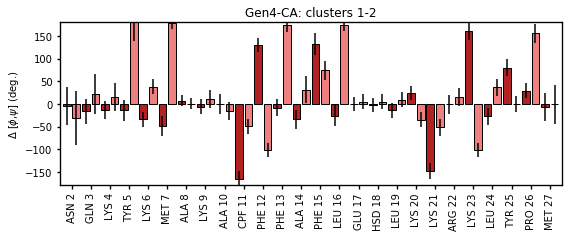

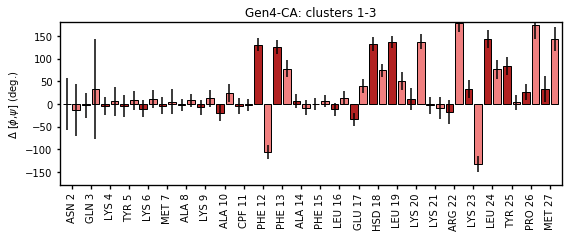

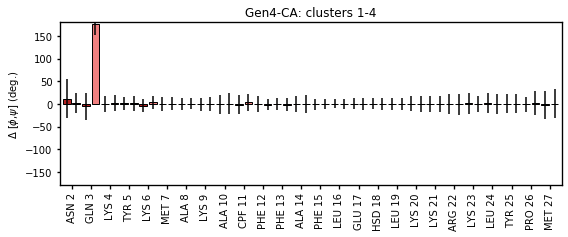

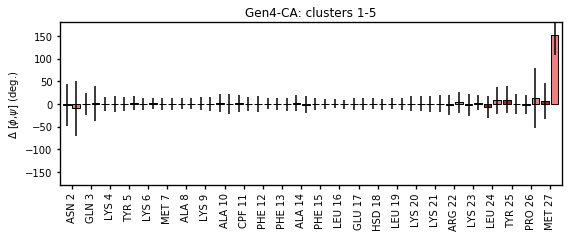

KeyboardInterrupt: 

In [8]:
### looking at backbone angles for individual REMD runs...
save_cell = False
top = 25
x_tick_lab = list(replica_c_data[0])
x_tick_lab = [ele[:-4] for ele in x_tick_lab]
x_tick_lab = x_tick_lab[::2]
x_tick_lab = [' '.join(ele.split('_')) for ele in x_tick_lab]
x_tick_loc = [i+0.5 for i in range(0,2*len(x_tick_lab),2)]
for i, m1 in enumerate(zip(mean_angles_all_clust,std_angles_all_clust)):
    if i >= top:
        break
    for j, m2 in enumerate(zip(mean_angles_all_clust,std_angles_all_clust)):
        if i == j:
            continue
        if j >= top:
            break
#         print(mean_angles_all_clust[j][35:42])
#         print(mean_angles_all_clust[i][35:42])
#         print(mean_angles_all_clust[j][35:42]-mean_angles_all_clust[i][35:42])
        mean_diff = mean_angles_all_clust[j]-mean_angles_all_clust[i]
#             mean_diff = np.abs(mean_diff)
        diff_gt = mean_diff[mean_diff > 180] 
        diff_gt = 360 - diff_gt
        mean_diff[mean_diff > 180] = diff_gt
        diff_lt = mean_diff[mean_diff < -180] 
        diff_lt = 360 + diff_lt
        mean_diff[mean_diff < -180] = diff_lt
#         print(mean_diff[35:42])
        std_diff = np.sqrt(np.power(std_angles_all_clust[i],2)+np.power(std_angles_all_clust[j],2))
        fig = plt.figure(figsize=(9,3)) # 9/3
        ax = plt.subplot()
        plt.xlim([-0.75,51.75])
        locs = [i for i in range(mean_diff.shape[0])]
        ax.bar(locs[0::2], mean_diff[0::2],color='firebrick',edgecolor='k', yerr=std_diff[0::2], error_kw={'elinewidth':1.5})
        ax.bar(locs[1::2], mean_diff[1::2],color='lightcoral',edgecolor='k', yerr=std_diff[1::2], error_kw={'elinewidth':1.5})
        plt.xticks(x_tick_loc, labels=x_tick_lab, rotation=90,fontname='Dejavu Sans', fontsize=10)
        plt.title('{}: clusters {}-{}'.format(plt_name, i+1,j+1),fontname='Dejavu Sans', fontsize=12)
        plt.ylabel(r'$\Delta$' +' ['+ r'$\phi$'+','+ r'$\psi$' + '] (deg.)',fontname='Dejavu Sans', fontsize=10)
        width=1.35
        ax.spines['left'].set_linewidth(width)
        ax.spines['bottom'].set_linewidth(width)
        ax.spines['right'].set_linewidth(width)
        ax.spines['top'].set_linewidth(width)
        ax.tick_params(width=width)
        plt.ylim(bottom=-180, top=180)
        if save_cell:
            plt.savefig('./cov_CA_angles/{}-clusters{}-{}.svg'.format(save_name,i+1,j+1), format='svg', dpi=1000, bbox_inches='tight')
        plt.show()
#         plt.clf()

    
            
        

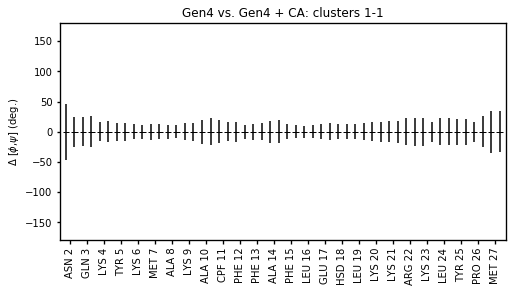

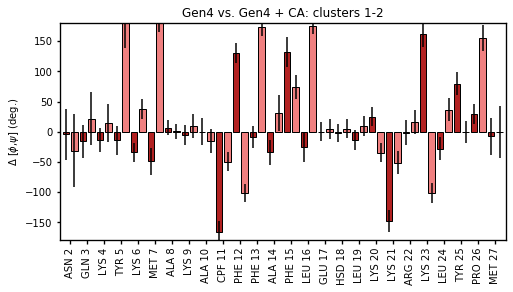

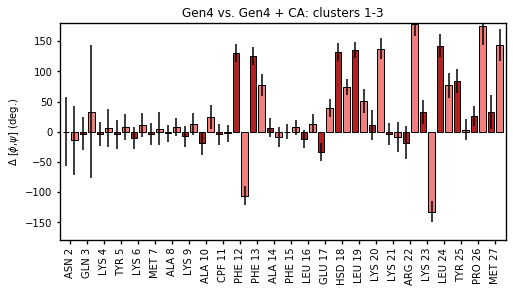

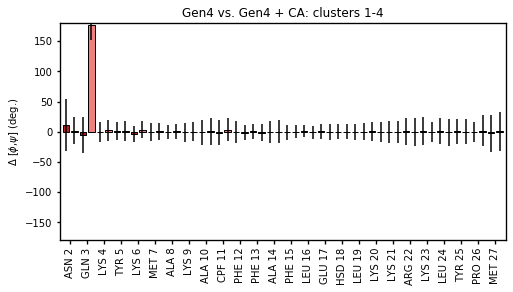

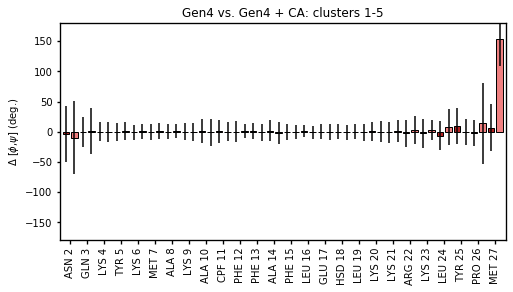

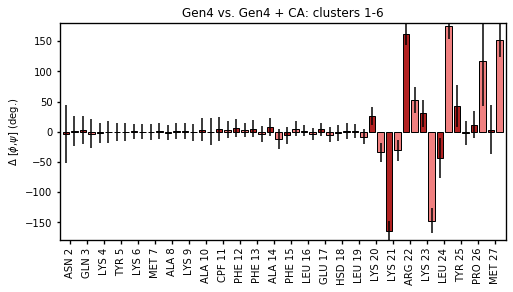

KeyboardInterrupt: 

In [9]:
### comparing backbone angles between runs
save_cell = False

def diff_traj_diff_plots(sim_1_mean_std,sim_2_mean_std,save_n,save_cell_):
    top = 20
    x_tick_lab = list(replica_c_data[0])
    x_tick_lab = [ele[:-4] for ele in x_tick_lab]
    x_tick_lab = x_tick_lab[::2]
    x_tick_lab = [' '.join(ele.split('_')) for ele in x_tick_lab]
    x_tick_loc = [i+0.5 for i in range(0,2*len(x_tick_lab),2)]
    for i, m1 in enumerate(zip(sim_1_mean_std[0],sim_1_mean_std[1])):
        if i >= top:
            break
        for j, m2 in enumerate(zip(sim_2_mean_std[0],sim_2_mean_std[1])):
            if j >= top:
                break
            mean_diff = mean_angles_all_clust[j]-mean_angles_all_clust[i]
#             mean_diff = np.abs(mean_diff)
            diff_gt = mean_diff[mean_diff > 180] 
            diff_gt = 360 - diff_gt
            mean_diff[mean_diff > 180] = diff_gt
            diff_lt = mean_diff[mean_diff < -180] 
            diff_lt = 360 + diff_lt
            mean_diff[mean_diff < -180] = diff_lt
            std_diff = np.sqrt(np.power(std_angles_all_clust[i],2)+np.power(std_angles_all_clust[j],2))
            fig = plt.figure(figsize=(8,4)) #9/3
            ax = plt.subplot()
            plt.xlim([-0.75,51.75])
            locs = [i for i in range(mean_diff.shape[0])]
            ax.bar(locs[0::2], mean_diff[0::2],color='firebrick',edgecolor='k', yerr=std_diff[0::2], error_kw={'elinewidth':1.5})
            ax.bar(locs[1::2], mean_diff[1::2],color='lightcoral',edgecolor='k', yerr=std_diff[1::2], error_kw={'elinewidth':1.5})
            plt.xticks(x_tick_loc, labels=x_tick_lab, rotation=90,fontname='Dejavu Sans', fontsize=10)
            plt.title('{}: clusters {}-{}'.format(save_n, i+1,j+1),fontname='Dejavu Sans', fontsize=12)
            plt.ylabel(r'$\Delta$' +' ['+ r'$\phi$'+','+ r'$\psi$' + '] (deg.)',fontname='Dejavu Sans', fontsize=10)
            width=1.35
            ax.spines['left'].set_linewidth(width)
            ax.spines['bottom'].set_linewidth(width)
            ax.spines['right'].set_linewidth(width)
            ax.spines['top'].set_linewidth(width)
            ax.tick_params(width=width)
            plt.ylim(bottom=-180, top=180)
            if save_cell:
                plt.savefig('{}-clusters{}-{}.svg'.format(save_n,i+1,j+1), format='svg', dpi=1000, bbox_inches='tight')
            plt.show()
        
#             mean_diff = sim_1_mean_std[0][i]-sim_2_mean_std[0][j]
#             mean_diff = np.abs(mean_diff)
#             diff_gt = mean_diff[mean_diff > 180] 
#             diff_gt = 360 - diff_gt
#             mean_diff[mean_diff > 180] = diff_gt
#             std_diff = np.sqrt(np.power(sim_1_mean_std[1][i],2)+np.power(sim_2_mean_std[1][j],2))
#             print(i,j)
#             fig = plt.figure(figsize=(8,3))
#             ax = plt.subplot()
#             plt.xlim([-1,52])
#             ax.bar([i for i in range(mean_diff.shape[0])], mean_diff, yerr=std_diff)
#             plt.xticks(x_tick_loc, labels=x_tick_lab, rotation=90)
#             plt.title('{}: clusters {}-{}'.format(save_n, i+1,j+1),fontname='Dejavu Sans', fontsize=12)
#             plt.ylabel('Angle difference (deg.)',fontname='Dejavu Sans', fontsize=10)
#             width=1.35
#             ax.spines['left'].set_linewidth(width)
#             ax.spines['bottom'].set_linewidth(width)
#             ax.spines['right'].set_linewidth(width)
#             ax.spines['top'].set_linewidth(width)
#             ax.tick_params(width=width)
#             plt.ylim([0,180])
#             if save_cell_:
#                 plt.savefig('{}-clusters{}-{}.svg'.format(save_n,i+1,j+1), format='svg', dpi=1000, bbox_inches='tight')
#             plt.show()

diff_traj_diff_plots(gen4, gen4_noncov_ca, 'Gen4 vs. Gen4 + CA', save_cell)
diff_traj_diff_plots(gen4, gen4_ca, 'Gen4 vs. Gen4-CA', save_cell)
diff_traj_diff_plots(gen4_noncov_ca,gen4_ca, 'Gen4 + CA vs. Gen4-CA', save_cell)